# Introduction to backward-modelling: TRF
In the forward-modelling example, we've introduced a method to map a stimuli to several noisy channels, thus (linearly) answering the question of "what stimuli is encoded where, and when?". Forward modelling is preferred in terms of interpretability (see Haufe, Stefan, et al. "On the interpretation of weight vectors of linear models in multivariate neuroimaging." Neuroimage 87 (2014): 96-110. for more details).However, the glaring weakness of forward modelling is that it deals with eeg channels independently and therefore cannot exploit the redundancy of information inter-channels in order to reduce the noise level. In addition, the number of channels is generally bigger than the number of regressors. For these reasons, backward modelling is statistically more powerful than forward modelling, while less interpretable. 

Here, we will see how to use the TRF models to handle backward modelling. Please note that this notebook will be updated at some point to describe a specific class so that you don't have to think about lags..etc

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale

# Data Generation

We generate a similar example as before but with more channels, as to exploit the number of sources to reduce noise

In [7]:
fs = 100
f_stim1 = 0.5
f_stim2 = 0.8
T = 600
time_array = np.linspace(0,T,int(T*fs))
stimuli_pos = np.clip(np.sin(2*np.pi*f_stim1*time_array),0,1)[:,np.newaxis]
stimuli_neg = np.clip(np.sin(2*np.pi*f_stim2*time_array),-1,0)[:,np.newaxis]
onsets_pos = signal.find_peaks(stimuli_pos[:,0])
onsets_neg = signal.find_peaks(stimuli_neg[:,0])
electrophysiological_data = np.hstack([np.roll(stimuli_pos,5) + np.random.random(stimuli_pos.shape) * 10, 
                                        np.roll(stimuli_pos,10) + np.random.random(stimuli_pos.shape) * 10,
                                        np.roll(stimuli_pos,15) + np.random.random(stimuli_pos.shape) * 10,
                                        np.roll(stimuli_pos,20) + np.random.random(stimuli_pos.shape) * 10,
                                        np.roll(stimuli_pos,25) + np.random.random(stimuli_pos.shape) * 10,
                                        np.roll(stimuli_neg,125) + np.random.random(stimuli_pos.shape) * 10,
                                        np.roll(stimuli_neg,150) + np.random.random(stimuli_pos.shape) * 10, 
                                        np.roll(stimuli_pos,5) + np.roll(stimuli_neg,150) + np.random.random(stimuli_pos.shape) * 10])

In [9]:
tmin = -1
tmax = 1
trf_forward = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))
trf_backward = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))

In [10]:
X = stimuli_pos
Y = electrophysiological_data

scores_forward = trf_forward.xval_eval(X, Y, scoring = 'R2')
scores_backward = trf_backward.xval_eval(Y, X, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'R2 sumary'}, xlabel='Alpha', ylabel='R2'>)

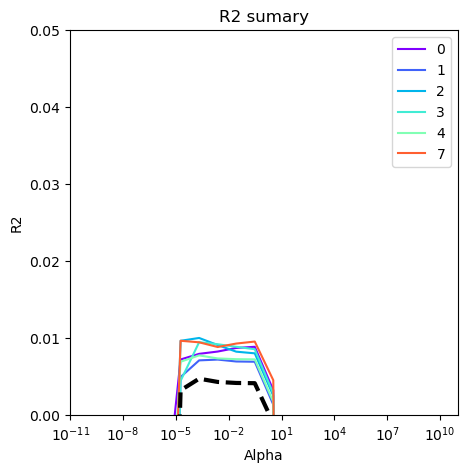

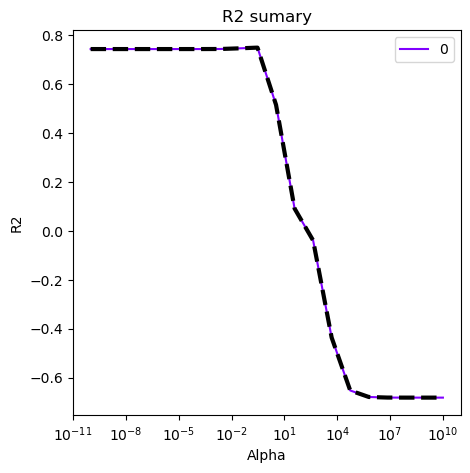

In [15]:
fig, ax = trf_forward.plot_score(minR2=0)
ax.set_ylim([0,0.05])
trf_backward.plot_score()

(<Figure size 1500x3200 with 8 Axes>,
 array([<Axes: title={'center': 'kernel sumary'}, xlabel='Time (s)', ylabel='0'>,
        <Axes: xlabel='Time (s)', ylabel='1'>,
        <Axes: xlabel='Time (s)', ylabel='2'>,
        <Axes: xlabel='Time (s)', ylabel='3'>,
        <Axes: xlabel='Time (s)', ylabel='4'>,
        <Axes: xlabel='Time (s)', ylabel='5'>,
        <Axes: xlabel='Time (s)', ylabel='6'>,
        <Axes: xlabel='Time (s)', ylabel='7'>], dtype=object))

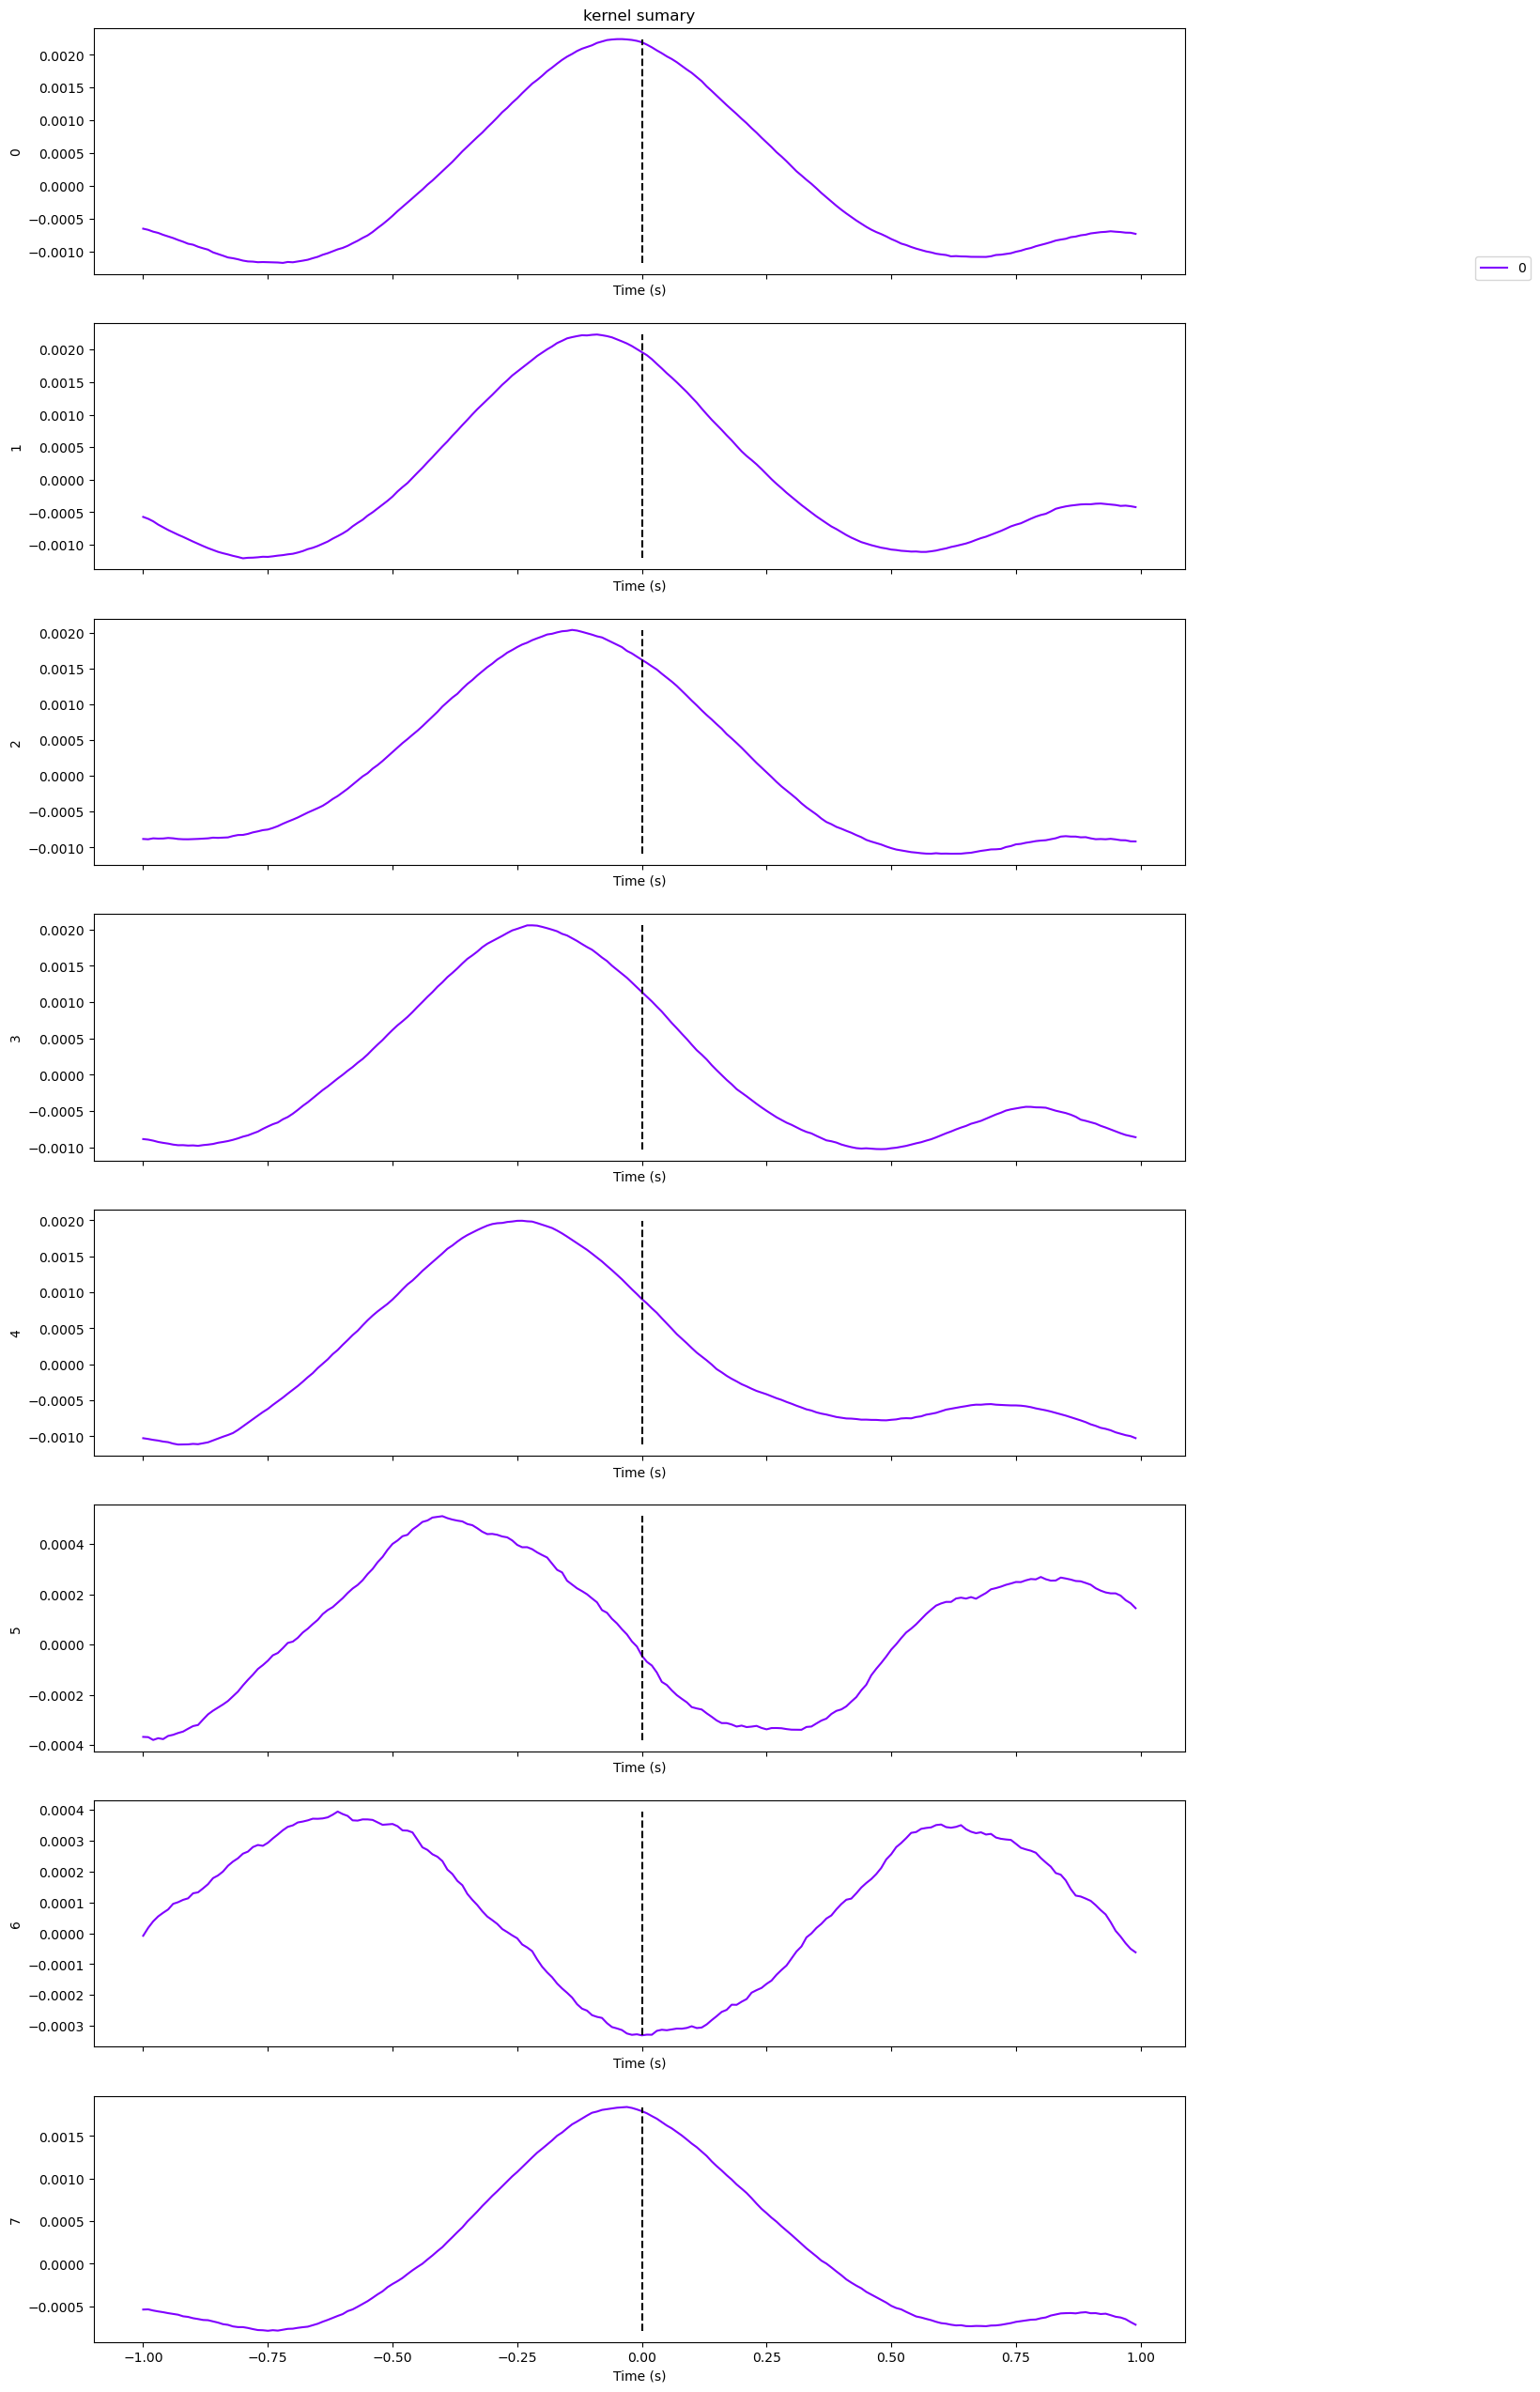

In [16]:
trf_backward.plot_kernel()